In [11]:
import os
import pandas as pd

# === 1. Çalışılacak klasör
klasor = "./etiketli_yorum_dosyaları"  # Aynı dizindeki tüm .csv dosyalar işlenecek

# === 2. CSV dosyalarını bul
csv_dosyalar = [f for f in os.listdir(klasor) if f.endswith(".csv")]

# === 3. Kişilik analizlerini tutacak liste
analizler = []

for dosya in csv_dosyalar:
    try:
        df = pd.read_csv(os.path.join(klasor, dosya), comment="#")

        if "predicted_label" not in df.columns:
            print(f"⚠️ Etiket bulunamadı: {dosya}")
            continue

        toplam = len(df)
        oranlar = df["predicted_label"].value_counts(normalize=True)

        profil = {
            "dosya": dosya,
            "toplam_yorum": toplam,
            "bilgilendirici_oran": oranlar.get("bilgilendirici", 0),
            "eleştirel_oran": oranlar.get("eleştirel", 0),
            "fanboy_oran": oranlar.get("fanboy/fangirl", 0),
            "nötr_oran": oranlar.get("nötr", 0),
            "şaka_oran": oranlar.get("şaka amaçlı", 0),
        }

        # === 4. Basit kişilik çıkarımı kuralları
        kisilik = []
        if profil["eleştirel_oran"] > 0.3:
            kisilik.append("Analitik ve sorgulayıcı")
        if profil["bilgilendirici_oran"] > 0.4:
            kisilik.append("Paylaşımcı ve açıklayıcı")
        if profil["fanboy_oran"] > 0.3:
            kisilik.append("Tutkulu ve savunmacı")
        if profil["şaka_oran"] > 0.2:
            kisilik.append("Eğlence odaklı, mizah anlayışı yüksek")

        profil["kişilik_profili"] = ", ".join(kisilik) if kisilik else "Dengeli veya nötr eğilim"
        analizler.append(profil)

    except Exception as e:
        print(f"❌ Hata ({dosya}): {e}")

# === 5. Tablolaştır ve kaydet
df_analiz = pd.DataFrame(analizler)
df_analiz.to_csv("kişilik_analizi_sonuçları.csv", index=False)
print("✅ Kişilik analizleri tamamlandı ve 'kişilik_analizi_sonuçları.csv' dosyasına kaydedildi.")

✅ Kişilik analizleri tamamlandı ve 'kişilik_analizi_sonuçları.csv' dosyasına kaydedildi.


In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

klasor = "./etiketli_yorum_dosyaları"  # Aynı dizindeki tüm .csv dosyalar işlenecek
csv_dosyalar = [f for f in os.listdir(klasor) if f.endswith(".csv")]

oyun_analizleri = []

for dosya in csv_dosyalar:
    try:
        df = pd.read_csv(os.path.join(klasor, dosya), comment="#")
        if "predicted_label" not in df.columns:
            continue

        toplam = len(df)
        oranlar = df["predicted_label"].value_counts(normalize=True)

        oyun_adi = os.path.splitext(dosya)[0].replace("etiketli_", "").replace("_yorumlar", "").replace("_", " ")

        profil = {
            "dosya": dosya,
            "oyun_adi": oyun_adi,
            "toplam_yorum": toplam,
            "bilgilendirici": oranlar.get("bilgilendirici", 0),
            "eleştirel": oranlar.get("eleştirel", 0),
            "fanboy/fangirl": oranlar.get("fanboy/fangirl", 0),
            "nötr": oranlar.get("nötr", 0),
            "şaka amaçlı": oranlar.get("şaka amaçlı", 0)
        }

        kisilik = []
        if profil["eleştirel"] > 0.3:
            kisilik.append("Analitik ve sorgulayıcı")
        if profil["bilgilendirici"] > 0.4:
            kisilik.append("Paylaşımcı ve açıklayıcı")
        if profil["fanboy/fangirl"] > 0.3:
            kisilik.append("Tutkulu ve savunmacı")
        if profil["şaka amaçlı"] > 0.2:
            kisilik.append("Eğlence odaklı, mizah anlayışı yüksek")

        profil["kişilik_profili"] = ", ".join(kisilik) if kisilik else "Dengeli veya nötr eğilim"
        oyun_analizleri.append(profil)

    except Exception as e:
        print(f"❌ Hata ({dosya}): {e}")

oyun_df = pd.DataFrame(oyun_analizleri)

# Örnek tür eşleşmeleri
oyun_turleri = {
    "Balatro": "Card, Strategy",
    "Hades": "Roguelike, Action",
    "Age of Empires IV Anniversary Edition": "Strategy, RTS",
    "Battlefield": "Shooter, War",
    "Rocket League": "Sports, Arcade"
}

oyun_df["tur"] = oyun_df["oyun_adi"].map(oyun_turleri).fillna("Bilinmiyor")

# Grup ortalamaları
tur_analizi = oyun_df.groupby("tur")[["bilgilendirici", "eleştirel", "fanboy/fangirl", "nötr", "şaka amaçlı"]].mean()

# === Tür bazlı stacked bar grafik
plt.figure(figsize=(12, 6))
tur_analizi.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("🎮 Oyun Türlerine Göre Etiket Dağılımı (Kişilik Eğilimleri)")
plt.xlabel("Oyun Türü")
plt.ylabel("Oran")
plt.xticks(rotation=45)
plt.legend(title="Etiket")
plt.tight_layout()
plt.savefig("tur_bazli_kisilik_analizi.png", dpi=300)
plt.close()

# === Tek tek oyun grafikleri
for _, row in oyun_df.iterrows():
    try:
        plt.figure(figsize=(6, 4))
        row[["bilgilendirici", "eleştirel", "fanboy/fangirl", "nötr", "şaka amaçlı"]].plot(
            kind="bar", color="skyblue", edgecolor="black"
        )
        plt.title(f"{row['oyun_adi']} - Etiket Dağılımı")
        plt.ylim(0, 1)
        plt.ylabel("Oran")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"oyun_grafik_{row['oyun_adi'].replace(' ', '_')}.png", dpi=300)
        plt.close()
    except Exception as e:
        print(f"❌ Grafik çizilemedi: {row['oyun_adi']} - {e}")

# Görsel tablo
oyun_df.to_csv("oyun_bazli_kisilik_analizi.csv", index=False)

C:\Users\enesk\AppData\Local\Temp\ipykernel_31148\4079529105.py:72: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from current font.
  plt.tight_layout()
C:\Users\enesk\AppData\Local\Temp\ipykernel_31148\4079529105.py:73: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from current font.
  plt.savefig("tur_bazli_kisilik_analizi.png", dpi=300)


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

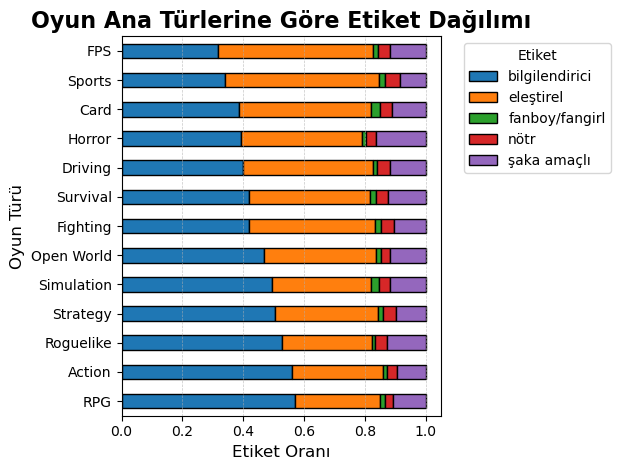

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Etiket sütunları
etiketler = ["bilgilendirici", "eleştirel", "fanboy/fangirl", "nötr", "şaka amaçlı"]

# Yükle
df = pd.read_csv("oyun_bazli_kisilik_analizi.csv")

if "tur" in df.columns:
    # Tek bir ana tür seçimi: sadece ilk türü dikkate alalım
    df["ana_tur"] = df["tur"].str.split(",").str[0].str.strip()

    # Ortalamayı grupla
    tur_df = df.groupby("ana_tur")[etiketler].mean().sort_values("bilgilendirici", ascending=False)

    # Grafik
    plt.figure(figsize=(12, 8))
    tur_df.plot(kind="barh", stacked=True, color=plt.get_cmap("tab10").colors, edgecolor='black')
    
    plt.title("Oyun Ana Türlerine Göre Etiket Dağılımı", fontsize=16, weight='bold')
    plt.xlabel("Etiket Oranı", fontsize=12)
    plt.ylabel("Oyun Türü", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Etiket", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig("tur_bazli_kisilik_analizi_okunabilir.png", dpi=300)
    plt.show()
else:
    print("⚠️ 'tur' sütunu bulunamadı. Grafik çizilemedi.")


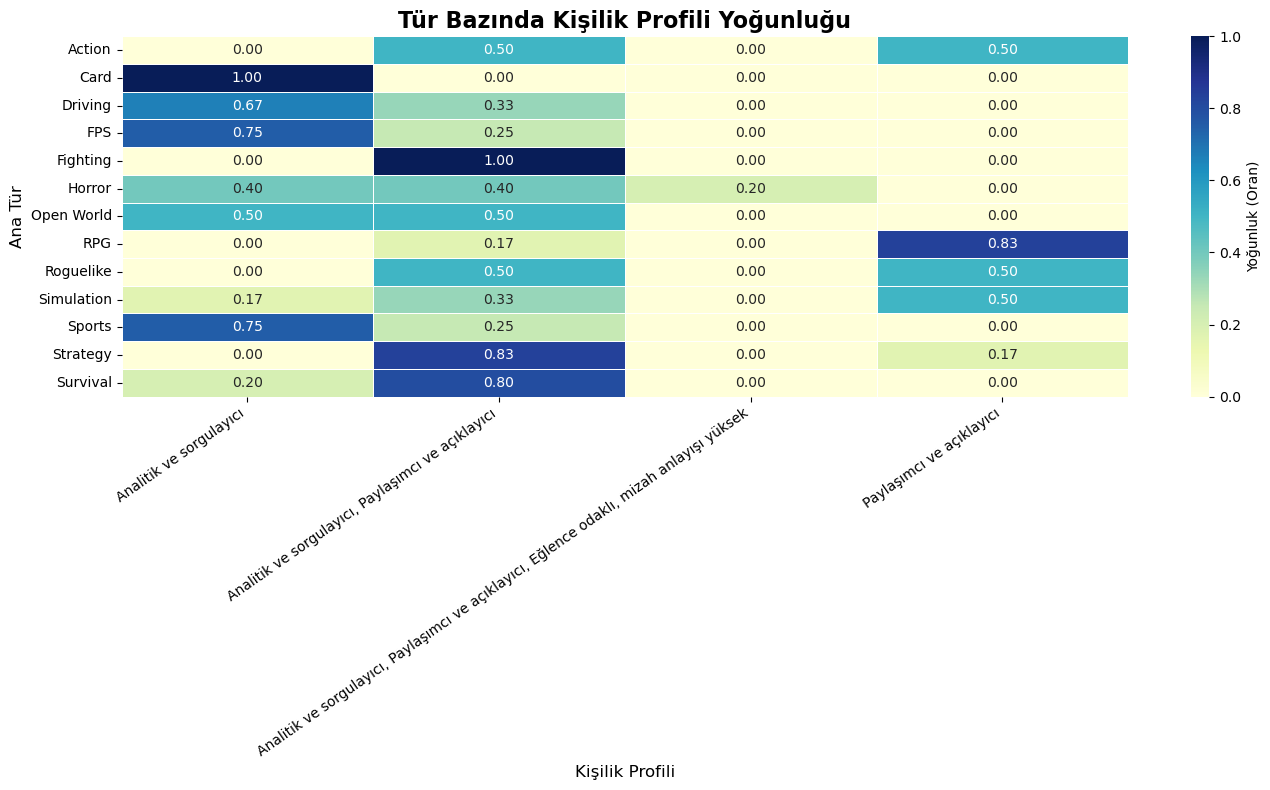

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. CSV'yi oku
df = pd.read_csv("oyun_bazli_kisilik_analizi.csv")

# === 2. Ana türü çıkar (ilk virgülden önceki tür)
df["ana_tur"] = df["tur"].str.split(",").str[0].str.strip()

# === 3. Kişilik profili dağılımını oluştur
pivot_df = df.groupby(["ana_tur", "kişilik_profili"]).size().unstack(fill_value=0)

# === 4. Her satırı (türü) normalize ederek oranlara çevir
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# === 5. Isı haritası çiz
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Yoğunluk (Oran)"}
)

plt.title("Tür Bazında Kişilik Profili Yoğunluğu", fontsize=16, weight="bold")
plt.xlabel("Kişilik Profili", fontsize=12)
plt.ylabel("Ana Tür", fontsize=12)
plt.xticks(rotation=35, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# === 6. Kaydet
plt.savefig("tur_bazli_kisilik_profili_isiharitasi.png", dpi=300)
plt.show()
